In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
from collections import defaultdict
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os 
import random
import cv2
from collections import Counter
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import load_img,img_to_array,to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152, EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
TRAIN_IMAGE_DIR = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/train/images'
TRAIN_LABEL_DIR = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/train/labels'
VALID_IMAGE_DIR = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/valid/images'
VALID_LABEL_DIR = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/valid/labels'
TEST_IMAGE_DIR = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/test/images'
TEST_LABEL_DIR = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/test/labels'

TARGET_SIZE = [224, 224]

def load_images_and_labels(image_dir, label_dir):
    images = []
    class_labels = []
    polygons_list = []

    for img_name in os.listdir(image_dir):
        if img_name.endswith(".jpg") or img_name.endswith(".png"):
            img_path = os.path.join(image_dir, img_name)
            image = cv2.imread(img_path)
            image = cv2.resize(image, TARGET_SIZE)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Normalize
            image = image.astype(np.float32) / 255.0

            label_path = os.path.join(label_dir, img_name.replace(".jpg", ".txt").replace(".png", ".txt"))
            polygons = []
            classes = []

            if os.path.exists(label_path):
                with open(label_path, "r") as f:
                    lines = f.read().strip().split("\n")
                for line in lines:
                    components = line.strip().split()
                    if len(components) > 1:
                        class_id = int(components[0])
                        coords = list(map(float, components[1:]))
                        # Only keep polygons with even number of coords
                        if len(coords) % 2 == 0:
                            classes.append(class_id)
                            polygons.append(coords)

            # Decide image-level class label
            if classes:
                image_level_label = classes[0]   # or use most frequent: max(set(classes), key=classes.count)
            else:
                image_level_label = 'no_fracture'  # your 'no_fracture' label

            images.append(image)
            class_labels.append(image_level_label)
            polygons_list.append(polygons)

    return np.array(images), np.array(class_labels), polygons_list


# Load images, class labels, and polygons
train_images, train_class_labels, train_polygons = load_images_and_labels(TRAIN_IMAGE_DIR, TRAIN_LABEL_DIR)
valid_images, valid_class_labels, valid_polygons = load_images_and_labels(VALID_IMAGE_DIR, VALID_LABEL_DIR)
test_images, test_class_labels, test_polygons = load_images_and_labels(TEST_IMAGE_DIR, TEST_LABEL_DIR)

print(f"Loaded {len(train_images)} images, {len(train_class_labels)} class labels, and {len(train_polygons)} sets of polygons.")
print(f"Loaded {len(valid_images)} images, {len(valid_class_labels)} class labels, and {len(valid_polygons)} sets of polygons.")
print(f"Loaded {len(test_images)} images, {len(test_class_labels)} class labels, and {len(test_polygons)} sets of polygons.")

Loaded 3631 images, 3631 class labels, and 3631 sets of polygons.
Loaded 348 images, 348 class labels, and 348 sets of polygons.
Loaded 169 images, 169 class labels, and 169 sets of polygons.


In [3]:
image = cv2.imread('/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/train/images/image1_1026_png.rf.de064b3ea83c63cf20650b3bda31dd53.jpg')
image = cv2.resize(image, TARGET_SIZE)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
mean_pixel = np.mean(np.array(gray))
print(mean_pixel)

23.098832110969386


In [4]:
# mean_pixels = []


# for img in train_images:
#     # Convert to grayscale
#     gray = cv2.cvtColor(img*255, cv2.COLOR_RGB2GRAY)
#     mean_pixel = np.mean(gray)
#     mean_pixels.append(mean_pixel)
#     if (mean_pixel <= 130) & (mean_pixel >= 120) :
#         mean_pixels.append(mean_pixel)
#         print(mean_pixel)
#         plt.imshow(img)
#         plt.show()

# print(len(mean_pixels))

In [5]:
# plt.figure(figsize=(8,5))
# plt.hist(mean_pixels, bins=50, color='blue', alpha=0.7)
# plt.xlabel('Fraction of black pixels')
# plt.ylabel('Number of images')
# plt.title('Distribution of black pixel ratio')
# plt.show()

In [6]:
# prepare CLAHE once
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

filtered_images = []
filtered_labels = []
mean_pixels = []

for img, label in zip(train_images, train_class_labels):
    # convert normalized [0,1] RGB → uint8 RGB, then to grayscale
    img_uint8 = (img * 255).astype(np.uint8)
    gray      = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2GRAY)
    
    # apply CLAHE on the gray image
    #gray_clahe = clahe.apply(gray)
    
    # compute mean on the CLAHE’d result
    mean_pixel = np.mean(gray)
    mean_pixels.append(mean_pixel)
    
    #  threshold as before
    if (mean_pixel >= 15) & (mean_pixel <= 130):
        filtered_images.append(img)
        filtered_labels.append(label)

print(f"Original images: {len(train_images)}")
print(f"Filtered images: {len(filtered_images)}")

Original images: 3631
Filtered images: 2996


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


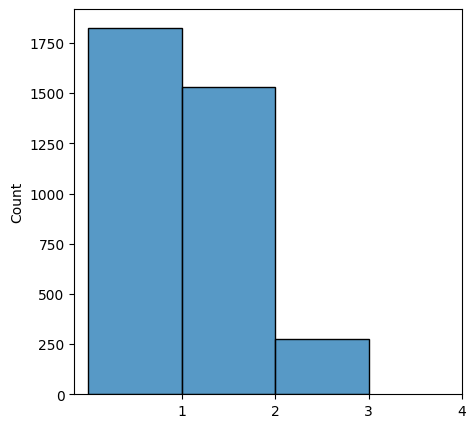

In [7]:
len_train_polygons=[]
for k in range(len(train_polygons)):
    a = len(train_polygons[k])
    len_train_polygons.append(a)
plt.subplots(figsize=(5,5))
sns.histplot(len_train_polygons,binwidth=1)
plt.xticks(np.arange(1, 5, 1))
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


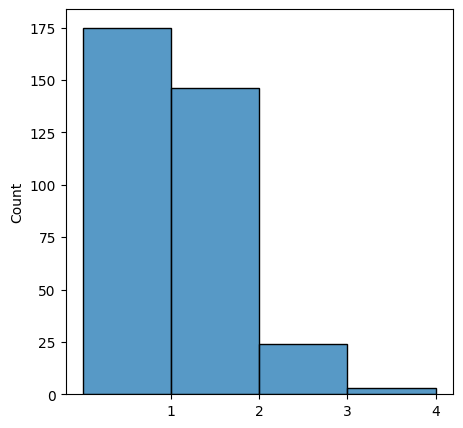

In [8]:
len_valid_polygons=[]
for k in range(len(valid_polygons)):
    a = len(valid_polygons[k])
    len_valid_polygons.append(a)
plt.subplots(figsize=(5,5))
sns.histplot(len_valid_polygons,binwidth=1)
plt.xticks(np.arange(1, 5, 1))
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


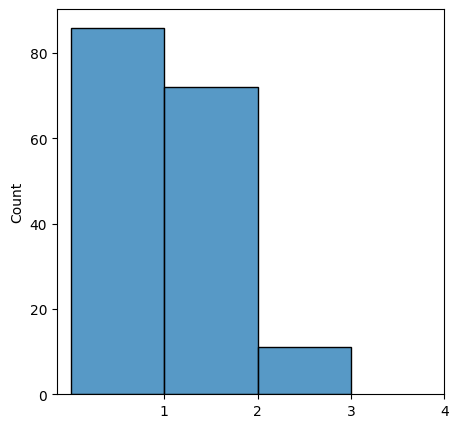

In [9]:
len_test_polygons=[]
for k in range(len(test_polygons)):
    a = len(test_polygons[k])
    len_test_polygons.append(a)
plt.subplots(figsize=(5,5))
sns.histplot(len_test_polygons,binwidth=1)
plt.xticks(np.arange(1, 5, 1))
plt.show()

In [10]:
# TARGET_SIZE = [225, 225]

# def load_images_and_labels(image_dir, label_dir):
#     images = []
#     class_labels = []
#     polygons = []

#     for img_name in os.listdir(image_dir):
#         if img_name.endswith(".jpg") or img_name.endswith(".png"):
#             img_path = os.path.join(image_dir, img_name)
#             image = cv2.imread(img_path)
#             image = cv2.resize(image, TARGET_SIZE)
#             image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#             label_path = os.path.join(label_dir, img_name.replace(".jpg", ".txt").replace(".png", ".txt"))
#             with open(label_path, "r") as f:
#                 label_content = f.read().strip()

#             if label_content:
#                 components = label_content.split()
#                 class_label = components[0]
#                 polygon_coords = list(map(float, components[1:]))

#                 # 🧐 Check: polygon length must be even
#                 if len(polygon_coords) % 2 != 0:
#                     #print(f"⚠ Skipping {img_name}: odd polygon length ({len(polygon_coords)})")
#                     continue
#             else:
#                 class_label = 'no_fracture'
#                 polygon_coords = []

#             images.append(image)
#             class_labels.append(class_label)
#             polygons.append(polygon_coords)

#     return np.array(images), np.array(class_labels), polygons


In [11]:
# train_images, train_class_labels, train_polygons = load_images_and_labels(TRAIN_IMAGE_DIR, TRAIN_LABEL_DIR)
# valid_images, valid_class_labels, valid_polygons = load_images_and_labels(VALID_IMAGE_DIR, VALID_LABEL_DIR)
# test_images, test_class_labels, test_polygons = load_images_and_labels(TEST_IMAGE_DIR, TEST_LABEL_DIR)

# print(f"Loaded {len(train_images)} images, {len(train_class_labels)} class labels, and {len(train_polygons)} sets of polygons.")
# print(f"Loaded {len(valid_images)} images, {len(valid_class_labels)} class labels, and {len(valid_polygons)} sets of polygons.")
# print(f"Loaded {len(test_images)} images, {len(test_class_labels)} class labels, and {len(test_polygons)} sets of polygons.")

In [12]:
# def visualize_images_with_polygons(images, class_labels, polygons_list, num_samples=20):
#     plt.figure(figsize=(20, 12))
    
#     indices = random.sample(range(len(images)), min(num_samples, len(images)))
#     print(indices)
    
#     for i, idx in enumerate(indices):
#         img = images[idx].copy()
#         label = class_labels[idx]
#         polygons = polygons_list[idx]

#         # Draw all polygons for this image
#         for poly in polygons:
#             if poly and len(poly) >= 4:
#                 pts = np.array(poly).reshape(-1, 2)

#                 # If coords are normalized (max <=1.1), scale to image size
#                 if np.max(pts) <= 1.1:
#                     pts[:, 0] *= img.shape[1]
#                     pts[:, 1] *= img.shape[0]

#                 pts = pts.astype(np.int32).reshape((-1,1,2))
#                 img = cv2.polylines(img, [pts], isClosed=True, color=(255,0,0), thickness=2)

#         plt.figure(figsize=(30,30))
#         plt.subplot(4, 5, i+1)
#         plt.imshow(img)
#         plt.title(f"Label: {label}")
#         plt.axis('off')
        
#     plt.tight_layout()
#     plt.show()

In [13]:
# visualize_images_with_polygons(train_images, train_class_labels, train_polygons, num_samples=1)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

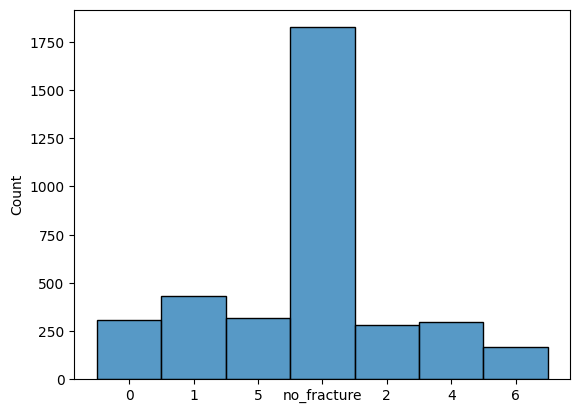

In [14]:
sns.histplot(train_class_labels)

In [15]:
# a = []
# for i in range(len(train_class_labels)):
#     if train_class_labels[i] == '6':
#         a.append(train_class_labels[i])

# len(a)

In [16]:
label_encoder = LabelEncoder()
train_labels_enc = label_encoder.fit_transform(filtered_labels)
valid_labels_enc = label_encoder.transform(valid_class_labels)
test_labels_enc = label_encoder.transform(test_class_labels)

print(label_encoder.classes_)  # to know the actual labels

['0' '1' '2' '4' '5' '6' 'no_fracture']


In [17]:

# Example: train_images = np.array([...]), train_labels = np.array([...])
class_groups = defaultdict(list)

for img, label in zip(filtered_images, train_labels_enc):  # assuming integer-encoded labels
    class_groups[label].append(img)

# Convert lists to arrays
for k in class_groups:
    class_groups[k] = np.array(class_groups[k])

In [18]:
no_fracture_label = 6 
train_images_list, train_labels_list = [], []

for label, images in class_groups.items():
    if len(images) == 0:
        continue
    if label == no_fracture_label:
        train_images_list.append(images)
        train_labels_list.extend([0] * len(images))
    else:
        train_images_list.append(images)
        train_labels_list.extend([1] * len(images))

train_images = np.concatenate(train_images_list, axis=0)
train_labels = np.array(train_labels_list)

print(np.unique(train_labels, return_counts=True))

(array([0, 1]), array([1443, 1553]))


In [19]:
# Example: train_images = np.array([...]), train_labels = np.array([...])
class_groups_1 = defaultdict(list)

for img, label in zip(valid_images, valid_labels_enc):  # assuming integer-encoded labels
    class_groups_1[label].append(img)

# Convert lists to arrays
for k in class_groups_1:
    class_groups_1[k] = np.array(class_groups_1[k])

In [20]:

valid_images_list, valid_labels_list = [], []

for label, images in class_groups_1.items():
    if len(images) == 0:
        continue
    if label == no_fracture_label:
        valid_images_list.append(images)
        valid_labels_list.extend([0] * len(images))
    else:
        valid_images_list.append(images)
        valid_labels_list.extend([1] * len(images))

valid_images = np.concatenate(valid_images_list, axis=0)
valid_labels = np.array(valid_labels_list)

print(np.unique(valid_labels, return_counts=True))# no_fracture_label = 0 (adjust if needed)

(array([0, 1]), array([175, 173]))


In [21]:
# Example: train_images = np.array([...]), train_labels = np.array([...])
class_groups_2 = defaultdict(list)

for img, label in zip(test_images, test_labels_enc):  # assuming integer-encoded labels
    class_groups_2[label].append(img)

# Convert lists to arrays
for k in class_groups_2:
    class_groups_2[k] = np.array(class_groups_2[k])

In [22]:
# no_fracture_label = 0 (adjust if needed)
test_images_list, test_labels_list = [], []

for label, images in class_groups_2.items():
    if len(images) == 0:
        continue
    if label == no_fracture_label:
        test_images_list.append(images)
        test_labels_list.extend([0] * len(images))
    else:
        test_images_list.append(images)
        test_labels_list.extend([1] * len(images))

test_images = np.concatenate(test_images_list, axis=0)
test_labels = np.array(test_labels_list)

print(np.unique(test_labels, return_counts=True))

(array([0, 1]), array([86, 83]))


In [23]:
# counter = Counter(train_labels)
# max_count = max(counter.values())

# balanced_images, balanced_labels = [], []

# for cls in [0,1]:
#     images = train_images[train_labels == cls]
#     count_needed = max_count - len(images)

#     # Always add original images
#     balanced_images.extend(images)
#     balanced_labels.extend([cls] * len(images))

#     # Add augmented images
#     for i in range(count_needed):
#         img = images[i % len(images)]
#         img = tf.image.random_flip_left_right(img)
#         img = tf.image.random_brightness(img, max_delta=0.1)
#         img = tf.image.random_contrast(img, 0.9, 1.1)
#         img = tf.image.resize(img, (225, 225))
#         balanced_images.append(img.numpy())
#         balanced_labels.append(cls)

# balanced_images = np.array(balanced_images)
# balanced_labels = np.array(balanced_labels)

# print("Balanced counts:", Counter(balanced_labels))

In [24]:
# for i in range(count_needed):
#         img = images[i % len(images)]
#         img = tf.image.random_flip_left_right(img)
#         img = tf.image.random_brightness(img, max_delta=0.1)
#         img = tf.image.random_contrast(img, 0.9, 1.1)
#         img = tf.image.resize(img, (225, 225))
#         balanced_images.append(img.numpy())
#         balanced_labels.append(cls)

In [25]:
# plt.imshow(train_images[1])

In [26]:
# train_images = train_images / 255.0
# valid_images = valid_images / 255.0
# test_images = test_images / 255.0

In [27]:
# train_images = train_images * 255.0
# valid_images = valid_images * 255.0
# test_images = test_images * 255.0

In [28]:
BATCH_SIZE = 32

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE)

valid_ds = tf.data.Dataset.from_tensor_slices((valid_images, valid_labels)).shuffle(1000).batch(BATCH_SIZE)

test_ds  = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).shuffle(1000).batch(BATCH_SIZE)



In [29]:
# valid_ds = tf.data.Dataset.from_tensor_slices((valid_images, valid_labels_enc)).shuffle(1000).batch(BATCH_SIZE)

In [30]:
# test_ds  = tf.data.Dataset.from_tensor_slices((test_images, test_labels_enc)).shuffle(1000).batch(BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

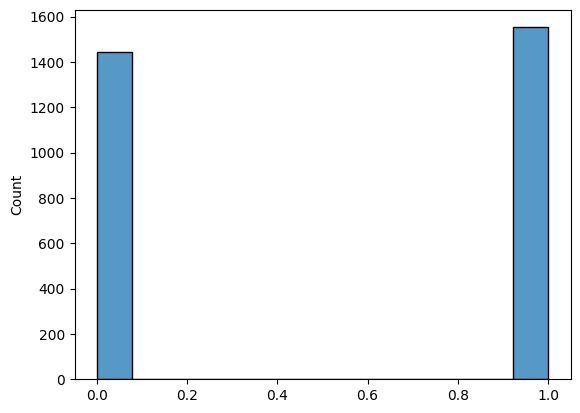

In [31]:
sns.histplot(train_labels)

In [32]:
optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4)

In [33]:
from tensorflow.keras.applications.resnet import preprocess_input

base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False

train_prep = preprocess_input(train_images)
valid_prep = preprocess_input(valid_images)

inputs = layers.Input(shape=(224,224,3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inputs, outputs)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    x=train_prep, y=train_labels, validation_data=(valid_prep,valid_labels), 
    epochs=15
    #callbacks=[callbacks.EarlyStopping(monitor="val_accuracy", patience=20, restore_best_weights=True)]
)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 49s 289ms/step - accuracy: 0.4978 - loss: 0.6975 - val_accuracy: 0.4971 - val_loss: 0.6935
Epoch 2/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.5078 - loss: 0.6954 - val_accuracy: 0.4971 - val_loss: 0.6938
Epoch 3/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.5230 - loss: 0.6925 - val_accuracy: 0.4971 - val_loss: 0.6939
Epoch 4/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.5107 - loss: 0.6942 - val_accuracy: 0.4971 - val_loss: 0.6940
Epoch 5/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.5134 - loss: 0.6960 - val_accuracy: 0.4971 - val_loss: 0.6941
Epoch 6/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.5234 - loss: 0.6921 - val_accuracy: 0.4971 - val_loss: 0.6936
Epoch 7/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.5124 - loss: 0.6942 - val_accuracy: 0.4971 - val_loss: 0.6940
Epoch 8/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accur

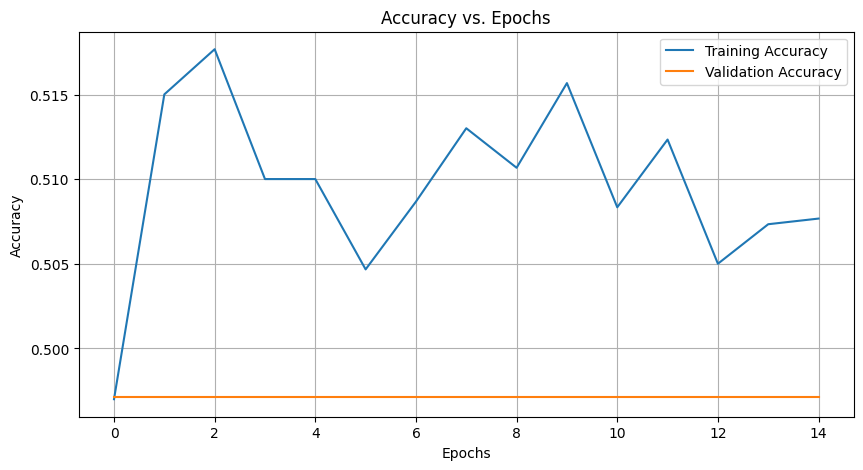

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step
Confusion Matrix:
 [[ 0 86]
 [ 0 83]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        86
           1       0.49      1.00      0.66        83

    accuracy                           0.49       169
   macro avg       0.25      0.50      0.33       169
weighted avg       0.24      0.49      0.32       169

ROC AUC: 0.5184225273185766


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


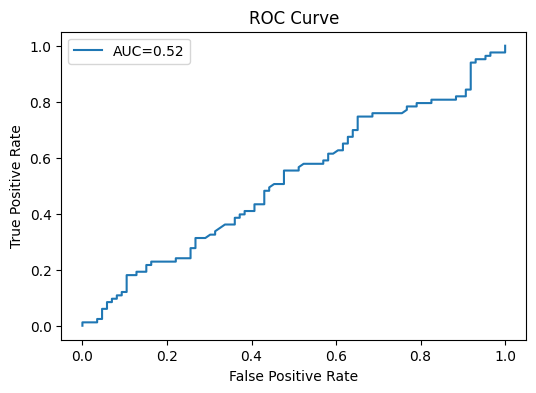

In [35]:
# Predict on test set
y_pred_probs = model.predict(test_ds).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)

# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

print("Confusion Matrix:\n", confusion_matrix(test_labels, y_pred))
print("\nClassification Report:\n", classification_report(test_labels, y_pred))
print("ROC AUC:", roc_auc_score(test_labels, y_pred_probs))

# ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_probs)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(test_labels, y_pred_probs):.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [36]:
from tensorflow.keras.applications.resnet import preprocess_input

train_prep = preprocess_input(train_images)
valid_prep = preprocess_input(valid_images)

base_model = ResNet152(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False

inputs = layers.Input(shape=(224,224,3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inputs, outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_prep, train_labels, validation_data=(valid_prep,valid_labels), epochs=20,
    #callbacks=[callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)]
)


234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 68s 460ms/step - accuracy: 0.5006 - loss: 0.8489 - val_accuracy: 0.4971 - val_loss: 0.7079
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 247ms/step - accuracy: 0.5260 - loss: 0.7190 - val_accuracy: 0.4914 - val_loss: 0.6933
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 243ms/step - accuracy: 0.5027 - loss: 0.7190 - val_accuracy: 0.4971 - val_loss: 0.6934
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 238ms/step - accuracy: 0.4901 - loss: 0.7092 - val_accuracy: 0.4971 - val_loss: 0.6933
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 238ms/step - accuracy: 0.5257 - loss: 0.7049 - val_accuracy: 0.5029 - val_loss: 0.7029
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 241ms/step - accuracy: 0.4948 - loss: 0.7088 - val_accuracy: 0.4971 - val_loss: 0.7043
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 240ms/step - accuracy: 0.5068 - loss: 0.7053 - val_accuracy: 0.4971 - val_loss: 0.7087
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 23

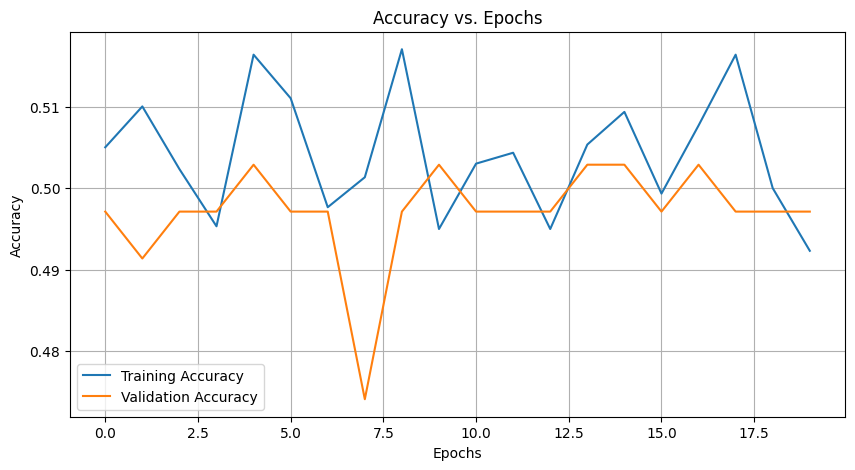

In [37]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step
Confusion Matrix:
 [[ 0 86]
 [ 0 83]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        86
           1       0.49      1.00      0.66        83

    accuracy                           0.49       169
   macro avg       0.25      0.50      0.33       169
weighted avg       0.24      0.49      0.32       169

ROC AUC: 0.5107873353880639


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


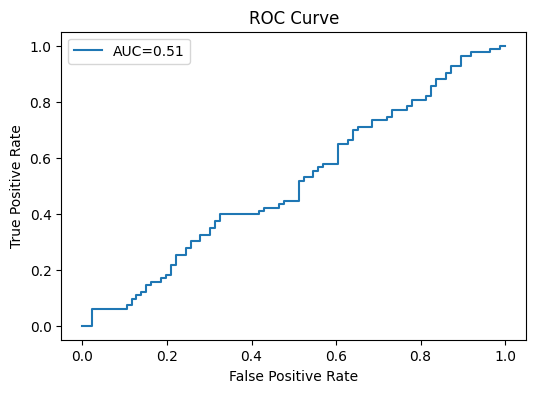

In [38]:
# Predict on test set
y_pred_probs = model.predict(test_ds).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)

# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

print("Confusion Matrix:\n", confusion_matrix(test_labels, y_pred))
print("\nClassification Report:\n", classification_report(test_labels, y_pred))
print("ROC AUC:", roc_auc_score(test_labels, y_pred_probs))

# ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_probs)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(test_labels, y_pred_probs):.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [39]:
# sns.histplot(augmented_labels)

In [40]:
# aug_images = np.array(augmented_images)
# aug_labels = np.array(augmented_labels)

# # Shuffle
# perm = np.random.permutation(len(aug_images))
# aug_images = aug_images[perm]
# aug_labels = aug_labels[perm]

In [41]:
# train_images = aug_images / 255.0
# valid_images = valid_images / 255.0
# test_images = test_images / 255.0

In [42]:
# num_classes = len(label_encoder.classes_)
# train_labels_cat = to_categorical(aug_labels, num_classes)
# valid_labels_cat = to_categorical(valid_labels_enc, num_classes)
# test_labels_cat = to_categorical(test_labels_enc, num_classes)

In [43]:
# datagen = ImageDataGenerator(
#     rotation_range=10,
#     width_shift_range=0.05,
#     height_shift_range=0.05,
#     zoom_rangfrom tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy("mixed_float16")

# # Setup EfficientNet
# base_model = EfficientNetB0(
#     weights="imagenet",
#     include_top=False,
#     input_shape=(225, 225, 3)
# )
# base_model.trainable = False

# inputs = Input(shape=(225, 225, 3))
# x = base_model(inputs, training=False)
# x = layers.GlobalAveragePooling2D()(x)
# x = layers.Dropout(0.5)(x)
# outputs = layers.Dense(NUM_CLASSES, activation="softmax", dtype="float32")(x)

# model = models.Model(inputs, outputs)
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(1e-3),
#     loss="categorical_crossentropy",
#     metrics=["accuracy"]
# )

# # Dataset pipeline
# train_ds = tf.data.Dataset.from_tensor_slices((aug_images, aug_labels_cat)).batch(8).prefetch(tf.data.AUTOTUNE)
# val_ds = tf.data.Dataset.from_tensor_slices((valid_images, valid_labels_cat)).batch(8).prefetch(tf.data.AUTOTUNE)

# # Train
# model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=20,
#     callbacks=[callbacks.EarlyStopping(monitor="val_accuracy", patience=8, restore_best_weights=True)]
# )e=0.1,
#     horizontal_flip=True,
#     brightness_range=[0.8, 1.2],
#     fill_mode='nearest'
# )
# datagen.fit(train_images)

In [44]:
# len(label_encoder.classes_)